# Comparing the Dynamics of Regular and Mass-Conserved FitzHugh–Nagumo Systems

**Motivation:**  
The FitzHugh–Nagumo (FHN) model is widely used for excitable dynamics with applications in biology and chemistry. Recently, active matter studies have highlighted the role of non-reciprocal energy injection and mass conservation. In this notebook we:
 
1. **Formulate the Models:** Define the regular FHN system and a mass‑conserved version.
2. **Local Dynamics Analysis:** Perform a linear stability analysis of the homogeneous steady states for both systems to reveal differences in stability and bifurcation behavior.
3. **Spatial Pattern Formation:** Use finite‑difference simulations to explore wave propagation, pattern formation, and the influence of the conservation law.
 
---
 
**Main Equations:**
 
**Regular FHN System:**
   $$
   \begin{aligned}
      \frac{\partial u}{\partial t} &= f(u,v) + D_u \nabla^2 u,\\[1mm]
      \frac{\partial v}{\partial t} &= \epsilon\, g(u,v) + D_v \nabla^2 v,
   \end{aligned}
   $$ 
   with
   $$ 
   
     f(u,v) = u-\frac{u^3}{3} - v,\quad 
     g(u,v)= u + a - b\,v.
   $$
 
**Mass-Conserved FHN System:**
   $$
   \begin{aligned}
      \frac{\partial u}{\partial t} &= -\nabla^2\Bigl[f(u,v) + D_u \nabla^2 \Bigr],\\[1mm]
      \frac{\partial v}{\partial t} &= -\nabla^2\Bigl[\epsilon\, g(u,v) + D_v \nabla^2 v\Bigr].
   \end{aligned}
   $$
 
In the following sections we implement and analyze these two models.

We use a finite‑difference scheme (with periodic boundary conditions) and a forward‑Euler time integrator.  

The parameters have been chosen to accentuate differences in spatial behavior between the two models. Experiment with the parameters (e.g. domain size, diffusion coefficients, or reaction parameters) to see more pronounced differences.

## 1. Model Formulation and Function Definitions

We define helper functions for the kinetics, the Laplacian (with periodic boundary conditions), and a plotting function.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [3]:

def laplacian_2d(field, dx):
    """
    Compute the 2D Laplacian using finite differences (with periodic boundary conditions).
    """
    return (np.roll(field, 1, axis=0) + np.roll(field, -1, axis=0) +
            np.roll(field, 1, axis=1) + np.roll(field, -1, axis=1) -
            4 * field) / dx**2

def f(u, v):
    """
    Activator function: f(u, v) = u - u^3/3 - v.
    """
    return u - (u**3)/3 - v

def g(u, v, a, b):
    """
    Inhibitor function: g(u, v) = u + a - b*v.
    
    Args:
        a, b (float): system parameters.
    """
    return u + a - b*v

def plot_field(ax, x, y, field, label):
    """
    Create a 2D pseudocolor plot for a given field.
    """
    p = ax.pcolormesh(x, y, field, shading='auto', cmap='inferno')
    cbar = plt.colorbar(p, ax=ax)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    cbar.set_label(label)
    return p

## 2. Local Dynamics Analysis: Homogeneous Steady States and Linear Stability

For homogeneous (spatially constant) solutions the diffusion terms vanish. The fixed point (FP)
must satisfy:

\begin{aligned}
f(u, v) &= u-\frac{u^3}{3} - v = 0,\\[1mm]
g(u, v) &= u + a - b\,v = 0.
\end{aligned}

Eliminating $v$ (i.e. $v = u - \frac{u^3}{3}$) $$ in the second equation leads to the cubic:
$$
\frac{b}{3}u^3 + (1 - b) u + a = 0.
$$
We use `np.roots` to solve this cubic and then compute the corresponding \(v\) values.
 
The Jacobian for the regular FHN (reaction part) is:

$$
J = \begin{pmatrix}
1-u^2 & -1\\[1mm]
\epsilon & -\epsilon\,b
\end{pmatrix}.
$$

The eigenvalues of \(J\) determine the local stability of the FP. For the mass‑conserved system, the
homogeneous FP are the same (the diffusion terms vanish), but spatial perturbations with nonzero wavenumbers alter the stability.

In [4]:
def steady_state_fp(a, b):
    """
    Compute the homogeneous fixed points for the FHN system by solving:
        (b/3) * u^3 + (1-b) * u + a = 0.
    Returns the array of u values and the corresponding v values.
    """
    # Coefficients for the cubic equation: (b/3)*u^3 + (1-b)*u + a = 0.
    coeffs = [b/3, 0, (1-b), a]
    u_roots = np.roots(coeffs)
    # Only keep the real-valued solutions
    u_fp = np.real(u_roots[np.isclose(np.imag(u_roots), 0)])
    v_fp = u_fp - (u_fp**3)/3  # from f(u,v)=0 => v = u - u^3/3
    return u_fp, v_fp

def jacobian(u_fp, epsilon, b):
    """
    Compute the Jacobian matrix at a homogeneous fixed point u_fp for the reaction part:
        J = [[1-u_fp^2, -1], [ε, -ε b]].
    """
    J = np.array([[1 - u_fp**2, -1],
                  [epsilon, -epsilon * b]])
    return J

def analyze_fp(a, b, epsilon):
    """
    For given parameters, compute the fixed points and their stability.
    Prints the FP and their Jacobian eigenvalues.
    """
    u_fp, v_fp = steady_state_fp(a, b)
    print("Fixed Points (u, v):")
    for u_val, v_val in zip(u_fp, v_fp):
        print("u = {:.4f}, v = {:.4f}".format(u_val, v_val))
        J = jacobian(u_val, epsilon, b)
        eigs = np.linalg.eigvals(J)
        print("Eigenvalues:", eigs, "\n")

In [5]:
# Example parameters for local analysis:
a = 1.1
b = 0.8
epsilon = 0.02
analyze_fp(a, b, epsilon)

Fixed Points (u, v):
u = -1.4484, v = -0.4355
Eigenvalues: [-1.07911401 -0.03481266] 



## 3. Spatial Pattern Formation: Simulations
 
We now simulate the spatially-extended versions of the systems by discretizing space (using finite differences) and time (using a forward-Euler scheme).
 
The following functions implement:
 
**Regular FHN:**
$$
   \begin{aligned}
   \partial_t u &= f(u,v) + D_u \nabla^2u,\\[1mm]
   \partial_t v &= \epsilon\,g(u,v) + D_v \nabla^2v,
   \end{aligned}
$$

 
**Mass-Conserved FHN:**
$$
   \begin{aligned}
   \partial_t u &= -\nabla^2\Bigl[f(u,v)+D_u \nabla^2u\Bigr],\\[1mm]
   \partial_t v &= -\nabla^2\Bigl[\epsilon\,g(u,v)+D_v \nabla^2v\Bigr].
   \end{aligned}
$$
 
You can choose which system to simulate by uncommenting the corresponding block.


In [6]:
def simulate_regular_fhn(T, dt, n_space, domain, a, b, epsilon, Du, Dv):
    """
    Simulate the regular FHN system
      ∂u/∂t = f(u,v) + Du ∇²u
      ∂v/∂t = ε g(u,v) + Dv ∇²v
    on a 2D domain using forward Euler.
    
    Parameters:
        T      : total simulation time.
        dt     : time step.
        n_space: number of spatial grid points per dimension.
        domain : (x_min, x_max) for both x and y.
        a, b   : parameters in g(u,v).
        epsilon: time scale factor for v.
        Du, Dv : diffusion coefficients.
    
    Returns:
        X, Y  : meshgrid arrays.
        t_vec : time vector.
        u, v  : arrays of the field over time (shape: [n_t+1, n_space, n_space]).
    """
    x_min, x_max = domain
    x = np.linspace(x_min, x_max, n_space)
    y = np.linspace(x_min, x_max, n_space)
    X, Y = np.meshgrid(x, y)
    dx = (x_max - x_min) / n_space
    n_t = int(T/dt)
    
    # Initial conditions: a small homogeneous base state with small random perturbations.
    u_list = [0.1 + 0.01 * np.random.randn(n_space, n_space)]
    v_list = [0.1 + 0.01 * np.random.randn(n_space, n_space)]
    
    for i in range(n_t):
        u_curr = u_list[-1]
        v_curr = v_list[-1]
        Lu = laplacian_2d(u_curr, dx)
        Lv = laplacian_2d(v_curr, dx)
        u_next = u_curr + dt * (f(u_curr, v_curr) + Du * Lu)
        v_next = v_curr + dt * (epsilon * g(u_curr, v_curr, a, b) + Dv * Lv)
        u_list.append(u_next)
        v_list.append(v_next)
    
    t_vec = np.linspace(0, T, n_t+1)
    return X, Y, t_vec, np.array(u_list), np.array(v_list)

In [7]:
def simulate_mass_conserved_fhn(T, dt, n_space, domain, a, b, epsilon, Du, Dv):
    """
    Simulate the mass-conserved FHN system
      ∂u/∂t = -∇² [ f(u,v) + Du ∇²u ]
      ∂v/∂t = -∇² [ ε g(u,v) + Dv ∇²v ]
    on a 2D domain using forward Euler.
    
    Parameters and outputs are similar to simulate_regular_fhn.
    """
    x_min, x_max = domain
    x = np.linspace(x_min, x_max, n_space)
    y = np.linspace(x_min, x_max, n_space)
    X, Y = np.meshgrid(x, y)
    dx = (x_max - x_min) / n_space
    n_t = int(T/dt)
    
    u_list = [0.1 + 0.01 * np.random.randn(n_space, n_space)]
    v_list = [0.1 + 0.01 * np.random.randn(n_space, n_space)]
    
    for i in range(n_t):
        u_curr = u_list[-1]
        v_curr = v_list[-1]
        Lu = laplacian_2d(u_curr, dx)
        Lv = laplacian_2d(v_curr, dx)
        inner_u = f(u_curr, v_curr) + Du * Lu
        inner_v = epsilon * g(u_curr, v_curr, a, b) + Dv * Lv
        L_inner_u = laplacian_2d(inner_u, dx)
        L_inner_v = laplacian_2d(inner_v, dx)
        u_next = u_curr - dt * L_inner_u
        v_next = v_curr - dt * L_inner_v
        u_list.append(u_next)
        v_list.append(v_next)
    
    t_vec = np.linspace(0, T, n_t+1)
    return X, Y, t_vec, np.array(u_list), np.array(v_list)

In [42]:
# Simulation parameters:
T       = 200         # total simulation time
dt      = 0.01      # time step
n_space = 50        # grid resolution
domain  = (0, 100)    # domain in x and y
a       = 0.7        # parameter a in g(u,v)
b       = 1.0        # parameter b in g(u,v)
epsilon = 0.02       # time scale factor
Du      = 0.5        # activator diffusion (small)
Dv      = 5.0        # inhibitor diffusion (large)

# Run the simulations:
X_reg, Y_reg, t_reg, u_reg, v_reg = simulate_regular_fhn(T, dt, n_space, domain, a, b, epsilon, Du, Dv)
X_mc, Y_mc, t_mc, u_mc, v_mc     = simulate_mass_conserved_fhn(T, dt, n_space, domain, a, b, epsilon, Du, Dv)

## 4. Visualization: Final Snapshots and Animation

We now compare final snapshots of the fields (activator u and inhibitor v) and animate the evolution of u for both models.

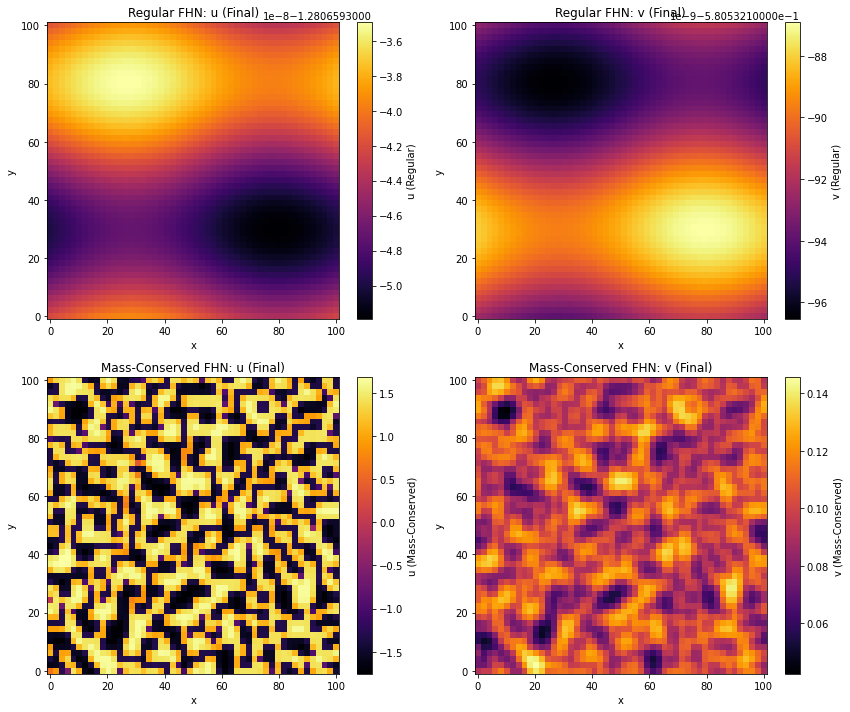

In [43]:
# Plot final snapshots for comparison:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
ax1, ax2, ax3, ax4 = axes[0,0], axes[0,1], axes[1,0], axes[1,1]

p1 = plot_field(ax1, X_reg, Y_reg, u_reg[-1], "u (Regular)")
ax1.set_title("Regular FHN: u (Final)")
p2 = plot_field(ax2, X_reg, Y_reg, v_reg[-1], "v (Regular)")
ax2.set_title("Regular FHN: v (Final)")
p3 = plot_field(ax3, X_mc, Y_mc, u_mc[-1], "u (Mass-Conserved)")
ax3.set_title("Mass-Conserved FHN: u (Final)")
p4 = plot_field(ax4, X_mc, Y_mc, v_mc[-1], "v (Mass-Conserved)")
ax4.set_title("Mass-Conserved FHN: v (Final)")
plt.tight_layout()
plt.show()

c:\Users\redad\anaconda3\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


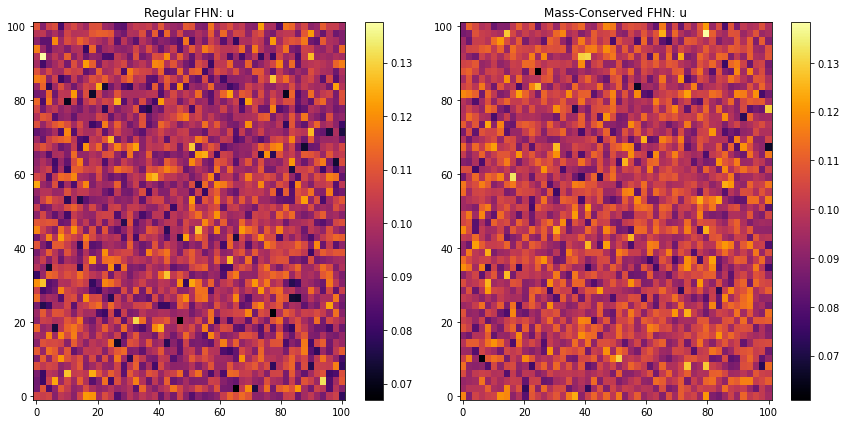

In [44]:
# Animate the evolution of the u-field for both systems:
fig2, (ax_reg_anim, ax_mc_anim) = plt.subplots(1, 2, figsize=(12,6))
plot_reg = ax_reg_anim.pcolormesh(X_reg, Y_reg, u_reg[0], shading='auto', cmap='inferno')
ax_reg_anim.set_title("Regular FHN: u")
plot_mc  = ax_mc_anim.pcolormesh(X_mc, Y_mc, u_mc[0], shading='auto', cmap='inferno')
ax_mc_anim.set_title("Mass-Conserved FHN: u")
fig2.colorbar(plot_reg, ax=ax_reg_anim)
fig2.colorbar(plot_mc, ax=ax_mc_anim)

def update(frame):
    # pcolormesh (with shading='auto') expects an array with shape (n_space-1, n_space-1)
    plot_reg.set_array(u_reg[frame][:-1, :-1].ravel())
    plot_mc.set_array(u_mc[frame][:-1, :-1].ravel())
    ax_reg_anim.set_title(f"Regular FHN: u, t = {t_reg[frame]:.2f}")
    ax_mc_anim.set_title(f"Mass-Conserved FHN: u, t = {t_mc[frame]:.2f}")
    return plot_reg, plot_mc

ani = FuncAnimation(fig2, update, frames=len(t_reg), interval=100, blit=False)
plt.tight_layout()
plt.show()

# ani.save("fhn_comparison.mp4", writer="ffmpeg", fps=10)

## 4. Bifurcation Structures and Robustness to Noise
 
In this section we:
 
1. Compare the dispersion relations for the homogeneous steady states of the two FHN models. This analysis reveals where (in wavenumber space) instabilities occur—indicating Hopf (k≈0) versus Turing (finite k) bifurcations.

2. Investigate the robustness of the emergent spatial wave patterns to added noise. We simulate both models with  increasing noise amplitude and display the final u-field snapshots. Experiment with these parameters to see how the bifurcation structure and pattern robustness change.


In [45]:
# For the homogeneous fixed point, we solve (b/3)u^3 + (1-b)u + a = 0.
def homogeneous_fp(a, b):
    coeffs = [b/3, 0, (1-b), a]
    r = np.roots(coeffs)
    # Only select the real solution:
    r_real = r[np.isclose(np.imag(r),0)]
    if len(r_real) == 0:
        raise RuntimeError("No real fixed point found!")
    return np.real(r_real[0])

# Define dispersion relation (linear stability) functions:
def dispersion_reg(k, u_fixed, epsilon, b, Du, Dv):
    """
    For the regular FHN model, the Fourier-space Jacobian is:
      J_reg(k) = [ [(1 - u_fixed^2) - Du k^2,   -1],
                   [ epsilon,                -epsilon*b - Dv k^2] ]
    Returns the maximum real part of its eigenvalues.
    """
    J = np.array([[ (1 - u_fixed**2) - Du*k**2, -1],
                  [ epsilon, -epsilon*b - Dv*k**2]])
    eigs = np.linalg.eigvals(J)
    return np.max(eigs.real)

def dispersion_mc(k, u_fixed, epsilon, b, Du, Dv):
    """
    For the mass-conserved FHN model, the linearized Fourier-space equation gives:
      J_mc(k) = [ [ k^2*(1 - u_fixed**2) - Du*k^4,  - k^2 ],
                  [ epsilon*k^2,           -epsilon*b*k^2 - Dv*k^4] ]
    Returns the maximum real part of its eigenvalues.
    """
    J_mc = np.array([[ k**2*(1 - u_fixed**2) - Du*k**4, - k**2],
                     [ epsilon*k**2, -epsilon*b*k**2 - Dv*k**4]])
    eigs = np.linalg.eigvals(J_mc)
    return np.max(eigs.real)

In [46]:
# Set parameters (try to choose a regime near an instability):
a_param = 0.7
b_param = 1.0
epsilon_val = 0.02
Du_val = 0.5
Dv_val = 5.0

In [47]:
# Compute homogeneous fixed point
u_fp = homogeneous_fp(a_param, b_param)
print("Homogeneous fixed point u =", u_fp)

# Sweep over a range of wavenumbers k
ks = np.linspace(0, 5, 300)
dispersion_regular = np.array([dispersion_reg(k, u_fp, epsilon_val, b_param, Du_val, Dv_val) for k in ks])
dispersion_mass = np.array([dispersion_mc(k, u_fp, epsilon_val, b_param, Du_val, Dv_val) for k in ks])

Homogeneous fixed point u = -1.2805791649874945


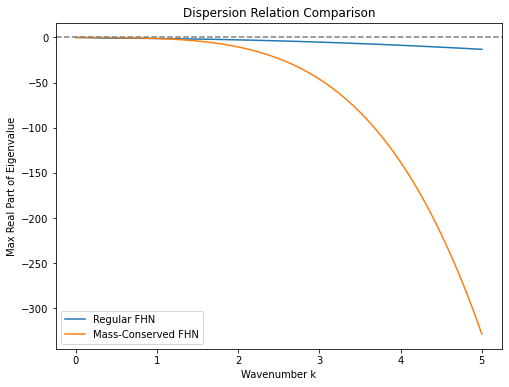

In [48]:
# Plot dispersion curves
plt.figure(figsize=(8, 6))
plt.plot(ks, dispersion_regular, label="Regular FHN")
plt.plot(ks, dispersion_mass, label="Mass-Conserved FHN")
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Wavenumber k")
plt.ylabel("Max Real Part of Eigenvalue")
plt.title("Dispersion Relation Comparison")
plt.legend()
plt.show()

## 5. Robustness Analysis to Noise and Parameter Perturbations
 
Next, we add stochastic noise to the update equations (using an Euler–Maruyama scheme) and compare the final snapshots of the activator u for both models. We run simulations with
different noise amplitudes to see how robust the spatial patterns are.
 
(Note: For simplicity, only the u-field is shown here; similar analysis can be performed for v.)


In [49]:
def simulate_regular_fhn_noise(T, dt, n_space, domain, a, b, epsilon, Du, Dv, sigma):
    """
    Simulate the regular FHN system with additive Gaussian noise.
    Noise of amplitude sigma is added at each time step.
    """
    x_min, x_max = domain
    x = np.linspace(x_min, x_max, n_space)
    y = np.linspace(x_min, x_max, n_space)
    X, Y = np.meshgrid(x, y)
    dx = (x_max - x_min)/n_space
    n_t = int(T/dt)
    
    # Initialize near a homogeneous state with small perturbations.
    u_list = [0.1 + 0.01 * np.random.randn(n_space, n_space)]
    v_list = [0.1 + 0.01 * np.random.randn(n_space, n_space)]
    
    for i in range(n_t):
        u_curr = u_list[-1]
        v_curr = v_list[-1]
        Lu = laplacian_2d(u_curr, dx)
        Lv = laplacian_2d(v_curr, dx)
        # Euler–Maruyama update (noise scaled with sqrt(dt))
        u_next = u_curr + dt*(f(u_curr, v_curr) + Du*Lu) + sigma*np.sqrt(dt)*np.random.randn(n_space, n_space)
        v_next = v_curr + dt*(epsilon*g(u_curr, v_curr, a, b) + Dv*Lv) + sigma*np.sqrt(dt)*np.random.randn(n_space, n_space)
        u_list.append(u_next)
        v_list.append(v_next)
    
    t_vec = np.linspace(0, T, n_t+1)
    return X, Y, t_vec, np.array(u_list), np.array(v_list)

def simulate_mass_conserved_fhn_noise(T, dt, n_space, domain, a, b, epsilon, Du, Dv, sigma):
    """
    Simulate the mass-conserved FHN system with additive Gaussian noise.
    Noise is added to the update equations as in the regular case.
    """
    x_min, x_max = domain
    x = np.linspace(x_min, x_max, n_space)
    y = np.linspace(x_min, x_max, n_space)
    X, Y = np.meshgrid(x, y)
    dx = (x_max - x_min)/n_space
    n_t = int(T/dt)
    
    u_list = [0.1 + 0.01 * np.random.randn(n_space, n_space)]
    v_list = [0.1 + 0.01 * np.random.randn(n_space, n_space)]
    
    for i in range(n_t):
        u_curr = u_list[-1]
        v_curr = v_list[-1]
        Lu = laplacian_2d(u_curr, dx)
        Lv = laplacian_2d(v_curr, dx)
        inner_u = f(u_curr, v_curr) + Du*Lu
        inner_v = epsilon*g(u_curr, v_curr, a, b) + Dv*Lv
        L_inner_u = laplacian_2d(inner_u, dx)
        L_inner_v = laplacian_2d(inner_v, dx)
        u_next = u_curr - dt*L_inner_u + sigma*np.sqrt(dt)*np.random.randn(n_space, n_space)
        v_next = v_curr - dt*L_inner_v + sigma*np.sqrt(dt)*np.random.randn(n_space, n_space)
        u_list.append(u_next)
        v_list.append(v_next)
    
    t_vec = np.linspace(0, T, n_t+1)
    return X, Y, t_vec, np.array(u_list), np.array(v_list)

In [58]:
# Simulation parameters for noise study:
T_noise    = 200
dt_noise   = 0.01
n_space_n  = 50
domain_n   = (0, 100)
# Use same reaction-diffusion parameters as before:
a_n = 0.7
b_n = 1.0
epsilon_n = 0.02
Du_n = 0.5
Dv_n = 5.0

# Noise amplitudes to test:
noise_levels = [0.0, 0.01, 0.5]


In [59]:
# For each noise level, simulate and store the final snapshot (u-field) for both models.
final_snapshots_reg = []
final_snapshots_mc = []

for sigma in noise_levels:
    Xn, Yn, t_vec_n, u_reg_noise, _ = simulate_regular_fhn_noise(T_noise, dt_noise, n_space_n, domain_n, a_n, b_n, epsilon_n, Du_n, Dv_n, sigma)
    final_snapshots_reg.append(u_reg_noise[-1])
    
    Xn_mc, Yn_mc, t_vec_n, u_mc_noise, _ = simulate_mass_conserved_fhn_noise(T_noise, dt_noise, n_space_n, domain_n, a_n, b_n, epsilon_n, Du_n, Dv_n, sigma)
    final_snapshots_mc.append(u_mc_noise[-1])

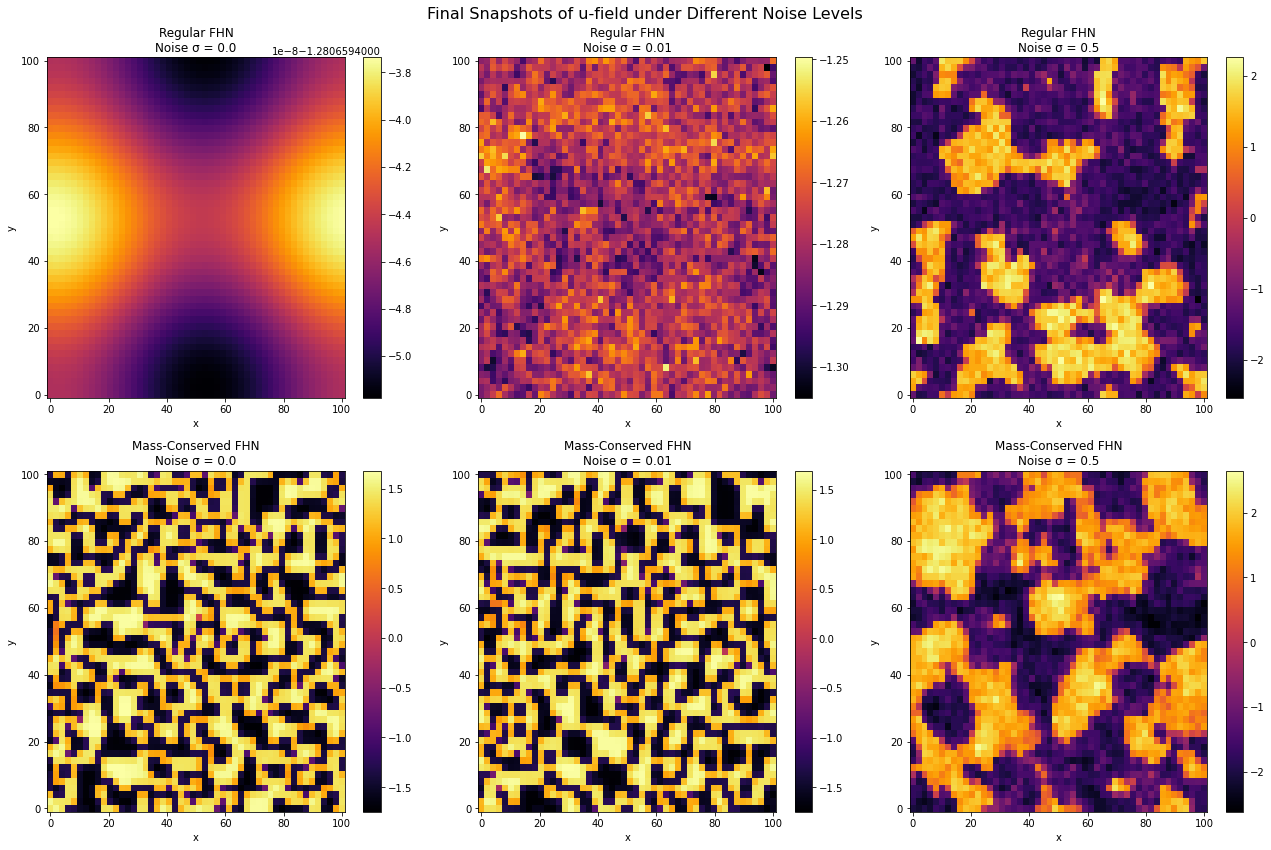

In [60]:
# Plot a comparison of final u-field snapshots for both models at different noise levels.
fig, axes = plt.subplots(2, len(noise_levels), figsize=(18, 12))

for i, sigma in enumerate(noise_levels):
    # Regular FHN subplot:
    ax = axes[0, i]
    p = ax.pcolormesh(Xn, Yn, final_snapshots_reg[i], shading='auto', cmap='inferno')
    ax.set_title(f"Regular FHN\nNoise σ = {sigma}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(p, ax=ax)
    
    # Mass-Conserved FHN subplot:
    ax_mc = axes[1, i]
    p_mc = ax_mc.pcolormesh(Xn_mc, Yn_mc, final_snapshots_mc[i], shading='auto', cmap='inferno')
    ax_mc.set_title(f"Mass-Conserved FHN\nNoise σ = {sigma}")
    ax_mc.set_xlabel("x")
    ax_mc.set_ylabel("y")
    fig.colorbar(p_mc, ax=ax_mc)

plt.suptitle("Final Snapshots of u-field under Different Noise Levels", fontsize=16)
plt.tight_layout()
plt.show()